In [6]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats     

import pygmsh

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

from Mesher import Mesh
import Matrix
import PoroElasticProperties as prop

Text(0, 0.5, 'y (m)')

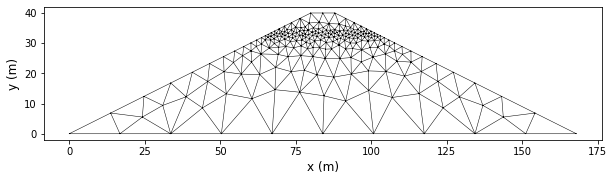

In [7]:
b = 8
dam_height = 40
water_table = 35
slope_left = 2
slope_right = 2

top_left = slope_left * dam_height  # crest left x
top_right = top_left + b
x_right = top_right + slope_right * dam_height

vertices = np.array([[0, 0],
                     [top_left, dam_height],
                     [top_right, dam_height],
                     [x_right, 0]])

# we can refine the mesh around an initial guess for the water table
wtable_guess = 33


# we create a mesh with triangle finite elements with the pygmsh library.

# we can have a per point cell resolution, telling pygmsh where we want finer elements
# there are multiple ways to do this, but a simple one is to make a list as long as our points
resolutions = np.array([5, 5, 5, 5,])

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # adding the line for the finer mesh
    
    geom.set_mesh_size_callback(lambda dim, tag, x, y, z, lc : 0.5 * np.abs(y - wtable_guess) + 1,
                                ignore_other_mesh_sizes=False)
    pleft = geom.add_point((0, wtable_guess), 0.01)
    pright = geom.add_point((x_right, wtable_guess), 0.01)
    l2 = geom.add_line(pleft, pright)
    geom.in_surface(surf, l2)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# we can use the mesh.plot() function to easily show it
fig, ax = mesh.plot()
fig.set_size_inches(10, 5)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

#plt.scatter(*mesh.nodes.T)

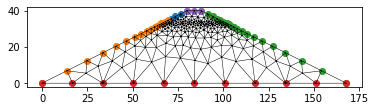

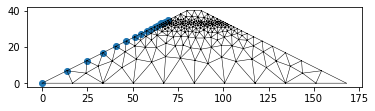

In [8]:
# we can select every boundary
left = np.argwhere(np.abs(mesh.nodes[:, 0]/slope_left - mesh.nodes[:, 1]) < 1e-2)
left_sat = np.intersect1d(np.argwhere((mesh.nodes[:, 1] <= water_table))[:, 0], left)
left_unsat = np.intersect1d(np.argwhere(mesh.nodes[:, 1] > water_table)[:, 0], left)

right = np.argwhere(np.abs((x_right - mesh.nodes[:, 0])/slope_right - mesh.nodes[:, 1]) < 1e-2)[:, 0]

bottom = np.argwhere(mesh.nodes[:, 1] == 0)[:, 0]
top = np.argwhere(mesh.nodes[:, 1] == dam_height)[:, 0]

mesh.plot()
for condition in [left_unsat, left_sat, right, bottom, top]:
    plt.scatter(*mesh.nodes[condition].T, alpha=1)

mesh.plot()
plt.scatter(*mesh.nodes[left_sat].T)


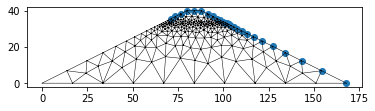

In [9]:
nodes_unsat = np.unique(np.hstack((left_unsat, top, right)))
mesh.plot()
plt.scatter(*mesh.nodes[nodes_unsat].T)

### Defining a relative permeability

We have to define a function that links the pressure to permeability, with a given threshold. We propose to use $\tanh(x)$, so that it is differentiable.

This $\tanh(x)$ function can be slightly modified so that it suits our needs. We will define our relative permability function as 

$$ k_{rel} = 0.5 \left(1 + \tanh\left(\frac{p}{p_0}\right)\right) + \epsilon, $$

where $p$ is the pressure at a given node, $p_0$ defines the *sharpness* of the function and $\epsilon$ is a very small number (to omit null permeability). Since our permeability is defined for every element and the pressure is defined at the nodes, we will compute the average pressure at a given element to compute the relative permeability. Let's see what this looks like: 

(-20.0, 20.0)

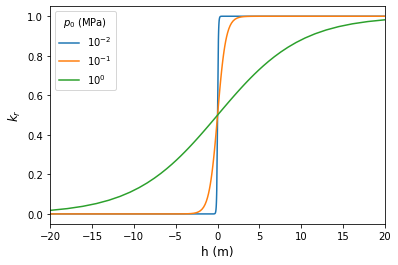

In [10]:
def tanh(p_res, p_0, eps=1e-10):
    y = 0.5 * (1.0 + np.tanh(p_res/p_0)) + eps
    return y

def relative_permeability(mesh, p_res, epsilon):
    k_rel = np.ones(mesh.ne)
    p_mean = np.ones(mesh.ne)

    for e in range(mesh.ne):
        
        n_e = mesh.connectivity[e]

        p = p_res[n_e].mean()

        k_rel[e] = tanh(p, epsilon)
        p_mean[e] = p
    
    return k_rel, p_mean


x = np.geomspace(1e-1, dam_height/2, 50)
x = np.hstack((-x[::-1], x))


epsilons = [1e-2, 1e-1, 1]
for eps in epsilons:
    y = tanh(x/10, eps) 
    plt.plot(x, y, label=f'10$^{{{np.log10(eps):.0f}}}$', alpha=1.0)#, marker='.')

plt.xlabel('h (m)')
plt.ylabel('$k_r$')
plt.legend(title='$p_0$ (MPa)')
plt.xlim(x.min(), x.max())


iteration 4 out of 50, relative change = 3.05 % 

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-11-49600a7a74c5>:65: RuntimeWarning: divide by zero encountered in true_divide
  error = np.nanmedian(np.abs((heads - heads_i)/heads_i))
<ipython-input-11-49600a7a74c5>:65: RuntimeWarning: invalid value encountered in true_divide
  error = np.nanmedian(np.abs((heads - heads_i)/heads_i))


iteration 50 out of 50, relative change = 0.90 % 

Text(0, 0.5, 'relative change')

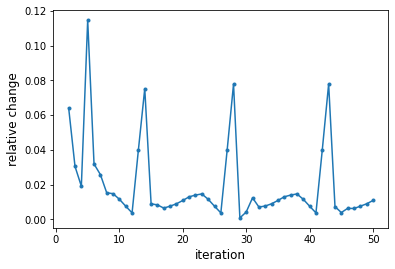

In [11]:
# we initialize a pressure vector
heads = np.zeros(mesh.nn)

# pressure is equal to the water table where it is saturated
heads[left_sat] = water_table

# pressure is equal to the elevation where it is unsaturated
heads[nodes_unsat] = mesh.nodes[nodes_unsat, 1]

# we also define a vector with a changing hydraulic conductivity to account for unsaturation
k0 = np.ones(mesh.nn)

# some parameters related to the solution
gammaw = 10     # weight of water
beta   = 0.9    # relaxation coefficient
eps    = 1   # sharpness of the relative permeability solution
tol    = 2e-5   # tolerance for the iterative scheme
imax   = 50     # maximum number of iterations

i = 0
error = np.inf

errors = np.zeros(imax) * np.nan

nodes_fixed = np.hstack((left_sat))

while (i < imax) and (tol < error):

    print(f'\riteration {i + 1} out of {imax}, relative change = {100 * error:.2f} % ', end='')

    b = 1 if i == 0 else beta

    C = Matrix.assemble_conductivity_matrix(mesh, k0)

    # the nodes which we will solve for at every iteration
    eq_to_solve = np.setdiff1d(np.arange(mesh.nn), nodes_fixed)    

    f = -C[eq_to_solve][:, nodes_fixed].dot(heads[nodes_fixed])
    
    h_i = linalg.spsolve(C[eq_to_solve][:, eq_to_solve], f)

    heads_i = heads.copy()
    heads[eq_to_solve] = h_i

    # we relax the solution at the current step
    heads = (1 - b) * heads_i + b * heads

    # we convert the head to pressure
    pressure = gammaw * (heads - mesh.nodes[:, 1])

    # saturation check
    fluxes = C.dot(heads)
    i_flux = np.argwhere(fluxes[nodes_unsat] < 0)
    cond1 = heads[nodes_unsat] > mesh.nodes[nodes_unsat, 1]
    cond2 = fluxes[nodes_unsat] < 0
    i_fixed = np.argwhere(cond1 & cond2)[:, 0]

    # re enforce boundary conditions
    nodes_fixed = np.hstack((left_sat, nodes_unsat[i_fixed]))
    heads[left_sat] = water_table
    heads[nodes_unsat[i_fixed]] = mesh.nodes[nodes_unsat[i_fixed], 1]

    k0, pmean = relative_permeability(mesh, pressure, eps)

    error = np.nanmedian(np.abs((heads - heads_i)/heads_i))
    errors[i] = error

    i += 1

plt.plot(np.arange(imax) + 1, errors, marker='.')
plt.xlabel('iteration')
plt.ylabel('relative change')


Text(0, 0.5, 'k$_r$')

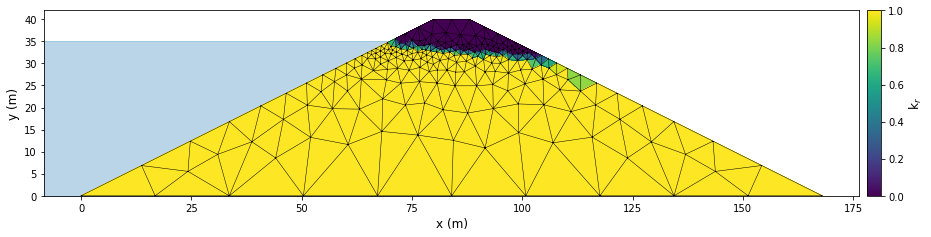

In [12]:
permeability = 0.5 * (1 + np.tanh(pressure/eps))

fig, ax, cb = mesh.plot(permeability, shading='flat')

xlim = ax.get_xlim()
ax.fill_between((xlim[0], mesh.nodes[:, 0].max()/2), water_table, 0, zorder=0, ec='tab:blue', alpha=0.3)
ax.set_xlim(xlim)
ax.set_ylim(0, None)
fig.set_size_inches(15, 15)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_ylabel('k$_r$')

Text(0, 0.5, 'k$_r$')

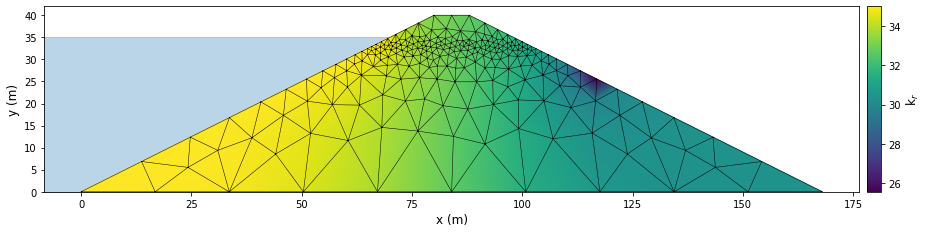

In [13]:
permeability = 0.5 * (1 + np.tanh(pressure/eps))

fig, ax, cb = mesh.plot(heads, shading='gouraud')

xlim = ax.get_xlim()
ax.fill_between((xlim[0], mesh.nodes[:, 0].max()/2), water_table, 0, zorder=0, ec='tab:blue', alpha=0.3)
ax.set_xlim(xlim)
ax.set_ylim(0, None)
fig.set_size_inches(15, 15)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_ylabel('k$_r$')